In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(42)

In [65]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import wishart_utils
import wishart_models

# Data Preparation

In [2]:
currency_subset_euro_df = pd.read_csv("currencies.csv")
currency_subset_euro_df.head()

,Date,Euro,Swiss Franc,U.K. Pound Sterling,U.S. Dollar,Day,Month,Year
0,1998-10-30,1.18398,1.3459,1.6773,1.0,30,10,1998
1,1998-11-02,1.18373,1.3477,1.6676,1.0,2,11,1998
2,1998-11-03,1.17525,1.3561,1.6552,1.0,3,11,1998
3,1998-11-04,1.17110,1.3689,1.6527,1.0,4,11,1998
4,1998-11-05,1.17706,1.3639,1.6594,1.0,5,11,1998


In [3]:
#plot the covariances for the EURO

covariances_ad = []
covariances_emp = []

for index, row in currency_subset_euro_df.iterrows():
    
    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    #mu_i = z_i.mean()
    mu_i = 0
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    
    covariances_emp.append(x_i)
    covariances_ad.append(x_i[:,0])

In [4]:
covariances_ad = np.array(covariances_ad)

cov_ad_euro = covariances_ad[:,0]
cov_ad_sf = covariances_ad[:,1]
cov_ad_pound = covariances_ad[:,2]
cov_ad_dollar = covariances_ad[:,3]

n_curr = 4

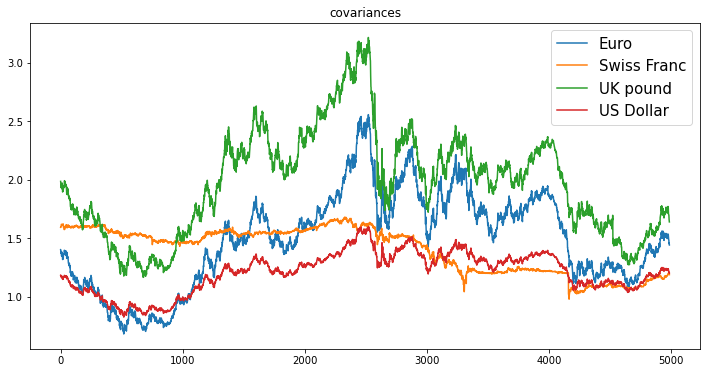

In [5]:
plt.figure(figsize=(12, 6))
legend_size = 15

plt.plot(cov_ad_euro, label="Euro")
plt.plot(cov_ad_sf, label="Swiss Franc")
plt.plot(cov_ad_pound, label="UK pound")
plt.plot(cov_ad_dollar, label="US Dollar")
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

# Create the data for LM(inv. Wishart)+GP

In [6]:
from copy import deepcopy

# specify simple priors
n_0 = 0
Psi_0 = 0.01 * np.eye(n_curr)

n_i = 0
Psi_i = deepcopy(Psi_0)

selected_points_mu = []
selected_points_cov = []
covs_emp = []
Psis = []
ns = []
mus = [] #compute the means of the values (instead of their covs) for the GWP later on
current_mu = 0

prev_month = 10

for index, row in currency_subset_euro_df.iterrows():
    
    month = row['Month']

    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    #mu_i = z_i.mean()
    mu_i = 0 
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    x_i = x_i.astype('float')
    #print("x_i: ", x_i)
    
    #reset when new month starts
    if month != prev_month:
        mus.append(current_mu/n_i)
        #covs_emp.append(Psi_i/n_i)
        covs_emp.append(np.outer(current_mu/n_i, current_mu/n_i))
        current_mu = 0
        
        ns.append(max(n_i, n_curr+1))
        #print("Psi: ", Psi_i)
        Psis.append(Psi_i)
        n_i = 0
        Psi_i = deepcopy(Psi_0)
        prev_month = month
        
        # add last dates of the months as selected points
        selected_points_mu.append(z_i)
        selected_points_cov.append(x_i)
        
        
    n_i += 1
    #print(np.shape(x_i))
    Psi_i += x_i
    current_mu += z_i

print(len(ns))
print(len(Psis))
print(len(mus))
print(len(selected_points_mu))
print(len(selected_points_cov))

235
235
235
235
235


(235, 4)


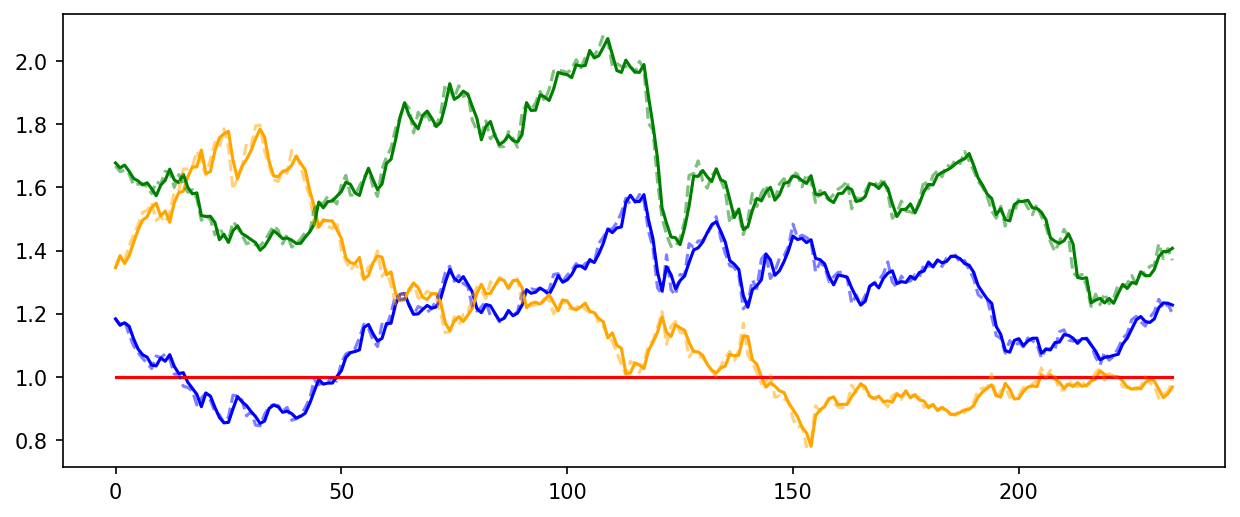

In [7]:
# plot means
print(np.shape(mus))
mus = np.array(mus)
selected_points_mu = np.array(selected_points_mu)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=150)

ax.plot(mus[:,0], color="blue")
ax.plot(mus[:,1], color="orange")
ax.plot(mus[:,2], color="green")
ax.plot(mus[:,3], color="red")
ax.plot(selected_points_mu[:,0], color="blue", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,1], color="orange", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,2], color="green", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,3], color="red", linestyle="--", alpha=0.5)

plt.show();

In [11]:
# get individual mus and Sigmas

Y_mu = []
Y_Sigma = []

t0_LM = time.time()
for i, p_ in enumerate(Psis):
    n_ = ns[i]
    mu_ = Inv_Wishart_sqrtm_bridge_mu(p_, n_)
    Sigma_ = Inv_Wishart_sqrtm_bridge_Sigma(p_, n_)
    Y_mu.append(mu_)
    Y_Sigma.append(Sigma_)

t1_LM = time.time()
print("LM timing: ", t1_LM - t0_LM)

print(Y_mu[0])
print(Y_Sigma[0])

LM timing:  0.05424809455871582
[0.2030855  0.19296732 0.24048152 0.14337419 0.19296732 0.25269068
 0.27336955 0.16298191 0.24048152 0.27336955 0.37401447 0.20311282
 0.14337419 0.16298191 0.20311282 0.15442844]
[[ 0.01513842 -0.00183279 -0.00228408 -0.00136176  0.01715155 -0.00206869
  -0.00257806 -0.00153703  0.02137476 -0.00257806 -0.00321285 -0.00191549
   0.01274355 -0.00153703 -0.00191549 -0.00114201]
 [-0.00183279  0.01466727 -0.00259645 -0.00154799 -0.00206869  0.01661976
  -0.00293063 -0.00174723 -0.00257806  0.02071203 -0.00365224 -0.00217745
  -0.00153703  0.01234843 -0.00217745 -0.00129819]
 [-0.00228408 -0.00259645  0.01351494 -0.00192916 -0.00257806 -0.00293063
   0.01531912 -0.00217745 -0.00321285 -0.00365224  0.01909113 -0.0027136
  -0.00191549 -0.00217745  0.01138206 -0.00161784]
 [-0.00136176 -0.00154799 -0.00192916  0.01560056 -0.00153703 -0.00174723
  -0.00217745  0.01767317 -0.00191549 -0.00217745 -0.0027136   0.02202482
  -0.00114201 -0.00129819 -0.00161784  0.013

In [12]:
# Prepare the X data

T = np.arange(1, len(Y_mu)+1)
V = np.arange(1, n_curr + 1)

X = []
for t in T:
    for v1 in V:
        for v2 in V:
            X.append([t, v1, v2])

X = np.array(X)            
print(X[:25])

[[1 1 1]
 [1 1 2]
 [1 1 3]
 [1 1 4]
 [1 2 1]
 [1 2 2]
 [1 2 3]
 [1 2 4]
 [1 3 1]
 [1 3 2]
 [1 3 3]
 [1 3 4]
 [1 4 1]
 [1 4 2]
 [1 4 3]
 [1 4 4]
 [2 1 1]
 [2 1 2]
 [2 1 3]
 [2 1 4]
 [2 2 1]
 [2 2 2]
 [2 2 3]
 [2 2 4]
 [2 3 1]]


(3760, 3760)


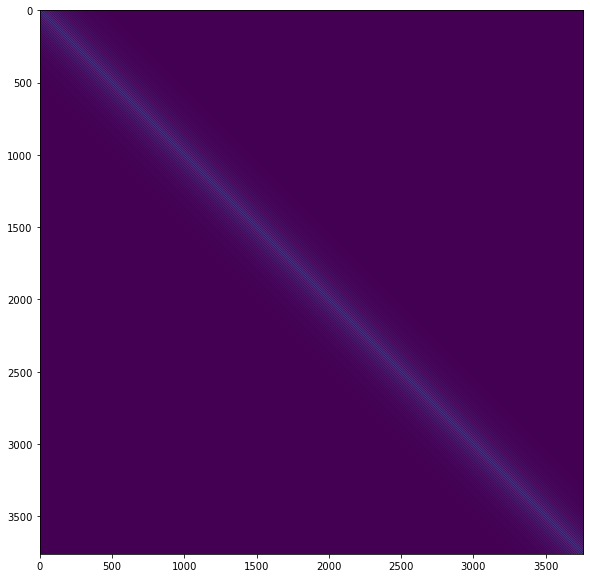

In [13]:
# build the kernel

def k_SEK(x, x_, s=1, l=3):
    return(s*np.exp(-(x-x_)**2 / (2*l**2)))

def k_RQ(x, x_, s=1, l=10, a=0.1):
    return(s**2 * (1 + (x-x_)**2/(2*a*l**2)))**(-a)

def k_OU(x, x_, s=1, l=9):
    return(s**2 * np.exp(-(np.abs(x-x_)/l)))
    
def k_dirac_soft(x, x_):
    if x == x_:
        return(1)
    else:
        return(0.1)
    
n = len(X)
K_XX = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        t_i = X[i,0]
        v1_i = X[i,1]
        v2_i = X[i,2]
        t_j = X[j,0]
        v1_j = X[j,1]
        v2_j = X[j,2]
        K_XX[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)

K_XX += 10e-6*np.eye(n) #for numerical issues
        
print(np.shape(K_XX))

plt.figure(figsize=(10,10))
plt.imshow(K_XX)
plt.show();

In [14]:
# prep Y data block

Y_Sigma_block = np.zeros((n,n))
idx = 0
for S in Y_Sigma:
    Y_Sigma_block[idx:idx+n_curr**2, idx:idx+(n_curr**2)] = S
    idx += n_curr**2

In [15]:
print(is_pos_def(K_XX))
print(is_pos_def(Y_Sigma_block))

True
True


In [16]:
# calculate GP stuff
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor


G_ = K_XX + Y_Sigma_block
t0_factor = time.time()
G = cho_factor(G_)
t1_factor = time.time()
time_factor = t1_factor - t0_factor
print("time to factor: ", time_factor)

time to factor:  0.882849931716919


(3760, 3)
[[1. 1. 1.]
 [1. 1. 2.]
 [1. 1. 3.]
 [1. 1. 4.]
 [1. 2. 1.]
 [1. 2. 2.]
 [1. 2. 3.]
 [1. 2. 4.]
 [1. 3. 1.]
 [1. 3. 2.]
 [1. 3. 3.]
 [1. 3. 4.]
 [1. 4. 1.]
 [1. 4. 2.]
 [1. 4. 3.]
 [1. 4. 4.]
 [2. 1. 1.]
 [2. 1. 2.]
 [2. 1. 3.]
 [2. 1. 4.]
 [2. 2. 1.]
 [2. 2. 2.]
 [2. 2. 3.]
 [2. 2. 4.]
 [2. 3. 1.]
 [2. 3. 2.]
 [2. 3. 3.]
 [2. 3. 4.]
 [2. 4. 1.]
 [2. 4. 2.]]
(3760, 3760)
(3760, 3760)


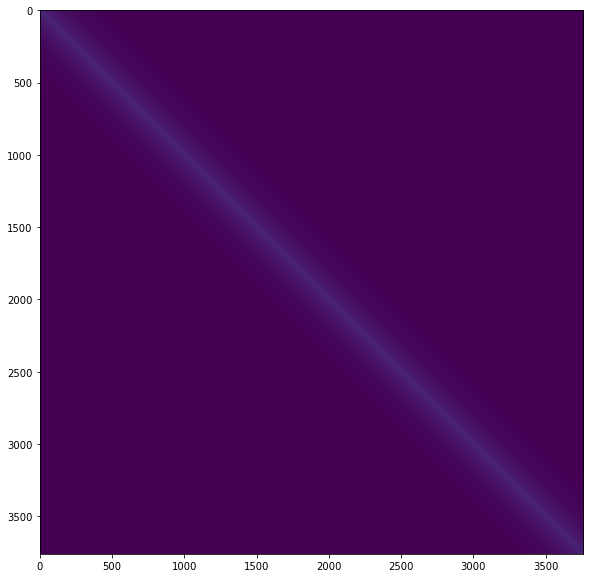

In [17]:
# create x, K_xx, K_xX

T_x = np.arange(1, 235+1) #just take the exact same range again
test_len = 235+10
#T_x = np.arange(1, test_len+1) #add 10 testpoints 

x = np.zeros((len(T_x) * len(V)**2, 3))
print(np.shape(x))
idx = 0
for t in T_x:
    for v1 in V:
        for v2 in V:
            x[idx] = [t, v1, v2]
            idx += 1
            
print(x[:30])

n_ = len(x)
K_xX = np.zeros((n_, n))
for i in range(n_):
    for j in range(n):
        t_i = x[i,0]
        v1_i = x[i,1]
        v2_i = x[i,2]
        t_j = X[j,0]
        v1_j = X[j,1]
        v2_j = X[j,2]
        K_xX[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        
print(np.shape(K_xX))

K_xx = np.zeros((n_, n_))
for i in range(n_):
    for j in range(n_):
        t_i = x[i,0]
        v1_i = x[i,1]
        v2_i = x[i,2]
        t_j = x[j,0]
        v1_j = x[j,1]
        v2_j = x[j,2]
        K_xx[i, j] = k_OU(t_i, t_j, s=1.002) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)


K_xx += np.eye(n_) * 1e-6

print(np.shape(K_xx))
plt.figure(figsize=(10,10))
plt.imshow(K_xx)
plt.show();

In [18]:
# do some inference
t0_solve = time.time()
A = cho_solve(G, K_xX.T).T
t1_solve = time.time()
time_solve = t1_solve - t0_solve
print("time to solve: ", time_solve)

Y_mu = np.array(Y_mu).reshape(-1)

out = {}

n_GP_samples = 50

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
t0_mu = time.time()
out["mpost"] = A @ Y_mu #m(x) + A @ (Y - mX)  # mean
t1_mu = time.time()
time_mu = t1_mu - t0_mu
print("time to compute mu: ", time_mu)

t0_cov = time.time()
out["vpost"] = K_xx - A @ K_xX.T  # covariance
t1_cov = time.time()
time_cov = t1_cov - t0_cov
print("time to compute Sigma: ", time_cov)

print("time for inference: ", time_factor + time_solve + time_mu + time_cov)

out["spost"] = multivariate_normal(
    out["mpost"].flatten(), out["vpost"], size=n_GP_samples
).T

time to solve:  5.069542169570923
time to compute mu:  0.0040569305419921875
time to compute Sigma:  4.804987192153931
time for inference:  10.761436223983765


In [19]:
print(np.shape(out["mpost"]))
print(np.shape(out["vpost"]))
print(np.shape(out["spost"]))

(3760,)
(3760, 3760)
(3760, 50)


In [20]:
# transform back and have a look

test_m = out["mpost"].reshape(-1, n_curr, n_curr)
matrices_back = []
for y in test_m:
    y_sqr = y@y.T + np.eye(n_curr) * 10e-8
    is_pos_def(y_sqr)
    matrices_back.append(y_sqr)
    
test_v = out["vpost"].diagonal().reshape(-1, n_curr, n_curr)
variances_back = []
for v in test_v:
    v_sqr = v@v.T + np.eye(n_curr) * 10e-8
    is_pos_def(v_sqr)
    variances_back.append(v_sqr)

In [21]:
value_counts = currency_subset_euro_df['Year'].value_counts()



dates = currency_subset_euro_df['Date']
years = currency_subset_euro_df['Year']
euro = currency_subset_euro_df['Euro']
swiss_franc = currency_subset_euro_df['Swiss Franc']
UK_pound = currency_subset_euro_df['U.K. Pound Sterling']
US_dollar = currency_subset_euro_df['U.S. Dollar']

year_idxs = []
idx = 0
for y in range(min(years), max(years)+1):
    year_idxs.append(idx)
    idx += value_counts[y]
    
    
print(year_idxs)

year_labels = years[year_idxs].values
print(year_labels)


[0, 44, 304, 563, 823, 1084, 1343, 1603, 1863, 2122, 2381, 2641, 2900, 3152, 3403, 3652, 3901, 4151, 4401, 4652, 4901]
[1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018]


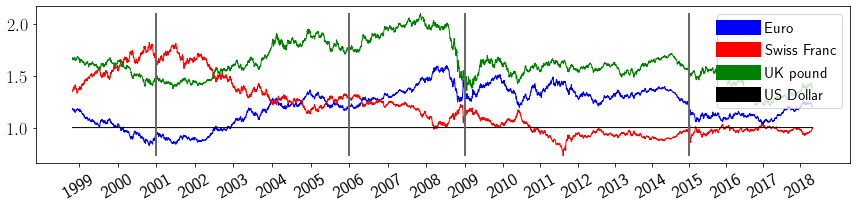

In [22]:
# plot the results

fig = plt.figure(figsize=(12,3))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=18)

lw = 1
legend_size = 15


plt.plot(euro, label="Euro", color='blue', lw=lw)
plt.plot(swiss_franc, label="Swiss Franc", color='red', lw=lw)
plt.plot(UK_pound, label="UK pound", color='green', lw=lw)
plt.plot(US_dollar, label="US Dollar", color='black', lw=lw)

y_min, y_max= 0.05, 0.95
# 2001
plt.axvline(year_idxs[1:][2], ymin=y_min, ymax=y_max, color='dimgrey', lw=2)
# 2006
plt.axvline(year_idxs[1:][7], ymin=y_min, ymax=y_max, color='dimgrey', lw=2)
# 2009
plt.axvline(year_idxs[1:][10], ymin=y_min, ymax=y_max, color='dimgrey', lw=2)
# 2015
plt.axvline(year_idxs[1:][16], ymin=y_min, ymax=y_max, color='dimgrey', lw=2)

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

leg = plt.legend(prop={'size': legend_size}) 
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(15.0)

plt.tight_layout()
plt.savefig('figures/currencies.pdf')
plt.show();

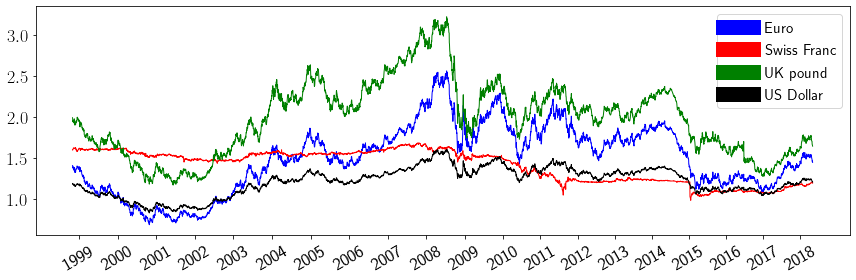

In [23]:
# plot the results

plt.figure(figsize=(12,4))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=18)

lw = 1
legend_size = 15


plt.plot(cov_ad_euro, label="Euro", color='blue', lw=lw)
plt.plot(cov_ad_sf, label="Swiss Franc", color='red', lw=lw)
plt.plot(cov_ad_pound, label="UK pound", color='green', lw=lw)
plt.plot(cov_ad_dollar, label="US Dollar", color='black', lw=lw)

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

leg = plt.legend(prop={'size': legend_size}) 
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(15.0)

plt.tight_layout()
plt.savefig('figures/currency_covariances.pdf')
plt.show();

In [24]:
print(covariances_emp[0])

[[1.4018086404 1.5935186820000002 1.9858896540000002 1.18398]
 [1.5935186820000002 1.8114468100000003 2.2574780700000003 1.3459]
 [1.9858896540000002 2.2574780700000003 2.81333529 1.6773]
 [1.18398 1.3459 1.6773 1.0]]


(4986, 4, 4)


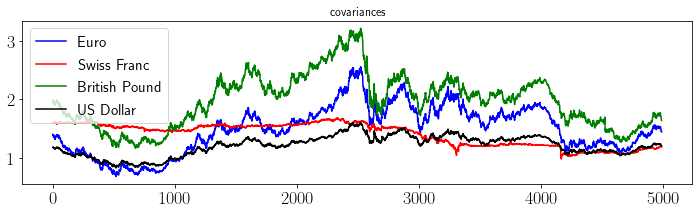

In [25]:
# plot empirical covariances
print(np.shape(covariances_emp))
covariances_emp = np.array(covariances_emp).astype(float)
corr_emp = np.zeros_like(covariances_emp)

# compute empirical covariances
cov_emp_euro = covariances_emp[:,0,0]
cov_emp_sf = covariances_emp[:,0,1]
cov_emp_bp = covariances_emp[:,0,2]
cov_emp_usd = covariances_emp[:,0,3]
        
plt.figure(figsize=(12, 3))
legend_size = 15

#plt.plot(corr_emp_euro, label="emp_0")
plt.plot(cov_emp_euro, label="Euro", color='blue')
plt.plot(cov_emp_sf, label="Swiss Franc", color='red')
plt.plot(cov_emp_bp, label="British Pound", color='green')
plt.plot(cov_emp_usd, label="US Dollar", color='black')
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

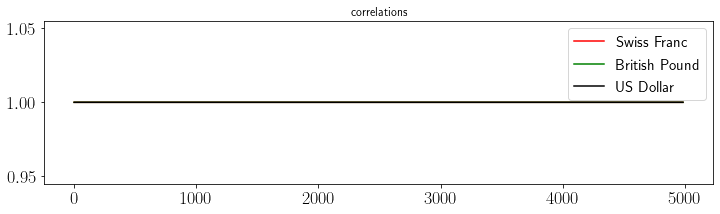

In [26]:
# compute the empirical correlations from the empirical covariances in a smart numpy way
for i in range(np.shape(covariances_emp)[-1]):
    for j in range(np.shape(covariances_emp)[-1]):
        corr_emp[:, i, j] = covariances_emp[:,i,j] / (np.sqrt(covariances_emp[:,i,i]) * np.sqrt(covariances_emp[:,j,j]))

# plot the results and compare with above
cov_emp_euro = covariances_emp[:,0,0]
cov_emp_sf = covariances_emp[:,0,1]
cov_emp_bp = covariances_emp[:,0,2]
cov_emp_usd = covariances_emp[:,0,3]
        
# plot the results and compare with above
corr_emp_euro = corr_emp[:,0,0]
corr_emp_sf = corr_emp[:,0,1]
corr_emp_bp = corr_emp[:,0,2]
corr_emp_usd = corr_emp[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

#plt.plot(corr_emp_euro, label="emp_0")
plt.plot(corr_emp_sf, label="Swiss Franc", color='red')
plt.plot(corr_emp_bp, label="British Pound", color='green')
plt.plot(corr_emp_usd, label="US Dollar", color='black')
plt.title("correlations")

plt.legend(prop={'size': legend_size});
plt.show();

(235, 4, 4)
(235, 4, 4)


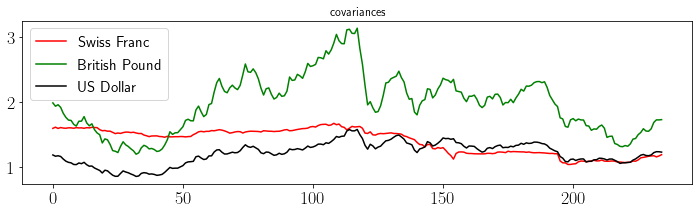

In [27]:
# plot empirical correlations from the Psis instead of every day
print(np.shape(Psis))
#Psis_emp = np.array(Psis)#.astype(float)
covs_emp = np.array(covs_emp).astype(float)
corr_emp = np.zeros_like(covs_emp)
print(np.shape(covs_emp))

# compute the empirical correlations from the empirical covariances in a smart numpy way
#for i in range(np.shape(Psis_emp)[-1]):
#    for j in range(np.shape(Psis_emp)[-1]):
#        corr_emp[:, i, j] = Psis_emp[:,i,j] / (np.sqrt(Psis_emp[:,i,i]) * np.sqrt(Psis_emp[:,j,j]))

for i in range(np.shape(covs_emp)[-1]):
    for j in range(np.shape(covs_emp)[-1]):
        corr_emp[:, i, j] = covs_emp[:,i,j] / (np.sqrt(covs_emp[:,i,i]) * np.sqrt(covs_emp[:,j,j]))

        
# plot the results and compare with above
cov_emp_euro = covs_emp[:,0,0]
cov_emp_sf = covs_emp[:,0,1]
cov_emp_bp = covs_emp[:,0,2]
cov_emp_usd = covs_emp[:,0,3]
        
plt.figure(figsize=(12, 3))
legend_size = 15

#plt.plot(corr_emp_euro, label="emp_0")
plt.plot(cov_emp_sf, label="Swiss Franc", color='red')
plt.plot(cov_emp_bp, label="British Pound", color='green')
plt.plot(cov_emp_usd, label="US Dollar", color='black')
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

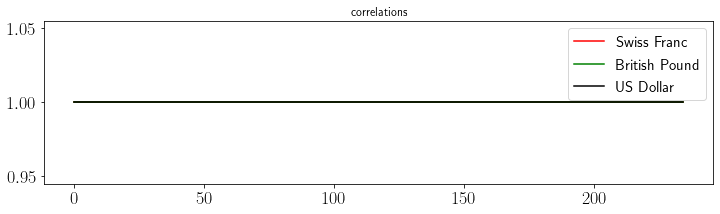

In [28]:
# plot the results and compare with above
corr_emp_euro = corr_emp[:,0,0]
corr_emp_sf = corr_emp[:,0,1]
corr_emp_bp = corr_emp[:,0,2]
corr_emp_usd = corr_emp[:,0,3]

plt.figure(figsize=(12, 3))
legend_size = 15

#plt.plot(corr_emp_euro, label="emp_0")
plt.plot(corr_emp_sf, label="Swiss Franc", color='red')
plt.plot(corr_emp_bp, label="British Pound", color='green')
plt.plot(corr_emp_usd, label="US Dollar", color='black')
plt.title("correlations")

plt.legend(prop={'size': legend_size});
plt.show();

In [29]:
matrices_back = np.array(matrices_back)
x1 = matrices_back[:,0,0]
x2 = matrices_back[:,0,1]
x3 = matrices_back[:,0,2]
x4 = matrices_back[:,0,3]

variances_back = np.array(variances_back)
v1 = np.sqrt(variances_back[:,0,0])
v2 = np.sqrt(variances_back[:,0,1])
v3 = np.sqrt(variances_back[:,0,2])
v4 = np.sqrt(variances_back[:,0,3])

In [30]:
# show the covariances at specific points in time

# 2001
cov_2001 = matrices_back[2 + 2*12]
cov_2006 = matrices_back[2 + 7*12]
cov_2009 = matrices_back[2 + 10*12]
cov_2015 = matrices_back[2 + 16*12]

<Figure size 864x288 with 0 Axes>

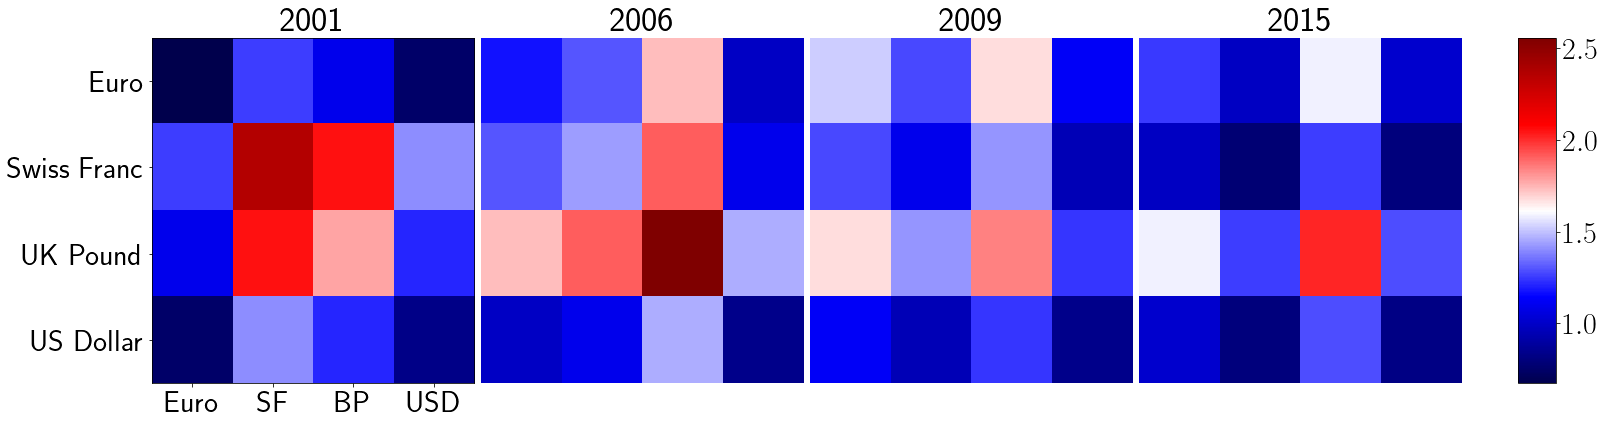

In [31]:
# plot the four matrices as heatmaps

plt.figure(figsize=(12,4))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('axes', labelsize=30)

title_size=35


titles = ['2001', '2006', '2009', '2015']

ticks = [0, 1, 2, 3]
ylabels = ['Euro', 'Swiss Franc', 'UK Pound', 'US Dollar']
xlabels = ['Euro', 'SF', 'BP', 'USD']

fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, figsize=(26,6))
covs = [cov_2001, cov_2006, cov_2009, cov_2015]


v_min = np.array(covs).min()
v_max = np.array(covs).max()

for i, ax in enumerate(axs.flat):
    if i == 0:
        #label the axis
        ax.set_yticks(ticks)
        ax.set_yticklabels(ylabels)
        ax.set_xticks(ticks)
        ax.set_xticklabels(xlabels)
    else:
        ax.set_axis_off()
        
    ax.set_title(titles[i], size=title_size)
    im = ax.imshow(covs[i], vmin=v_min, vmax=v_max, aspect='auto', cmap='seismic') #RdGy, bwr, RdBu, coolwarm, seismic
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

# plt.tight_layout() don't use tight_layout here.
plt.savefig('figures/selected_covs.pdf', bbox_inches='tight')
plt.show();

In [32]:
cov_samples = out["spost"]
print(np.shape(cov_samples))

cov_samples = np.swapaxes(cov_samples, 0, 1)
cov_samples = cov_samples.reshape(n_GP_samples, -1, n_curr, n_curr,)
print(np.shape(cov_samples))

cov_samples_sqr = np.zeros_like(cov_samples)
for i in range(n_GP_samples):
    for j in range(cov_samples.shape[1]):
        X_ = cov_samples[i, j, :, :]
        X_2 =  X_ @ X_.T 
        is_pos_def(X_2)
        cov_samples_sqr[i, j, :, :] = X_2

print(np.shape(cov_samples_sqr))
print(cov_samples_sqr[-1, -1, :, :])

(3760, 50)
(50, 235, 4, 4)
(50, 235, 4, 4)
[[1.06268657 0.68267534 1.07240892 0.73126392]
 [0.68267534 0.45197713 0.70553188 0.46979431]
 [1.07240892 0.70553188 1.14540346 0.73447125]
 [0.73126392 0.46979431 0.73447125 0.50443521]]


In [33]:
# draw 4 samples per year and plot them 

cov_samples_2001 = cov_samples_sqr[:4, 2 + 2*12, : ,:]
cov_samples_2006 = cov_samples_sqr[:4, 2 + 7*12, : ,:]
cov_samples_2009 = cov_samples_sqr[:4, 2 + 10*12, : ,:]
cov_samples_2015 = cov_samples_sqr[:4, 2 + 16*12, : ,:]
print(cov_samples_2001.shape)
print(v_min, v_max)

(4, 4, 4)
0.6729751043866847 2.559031868058129


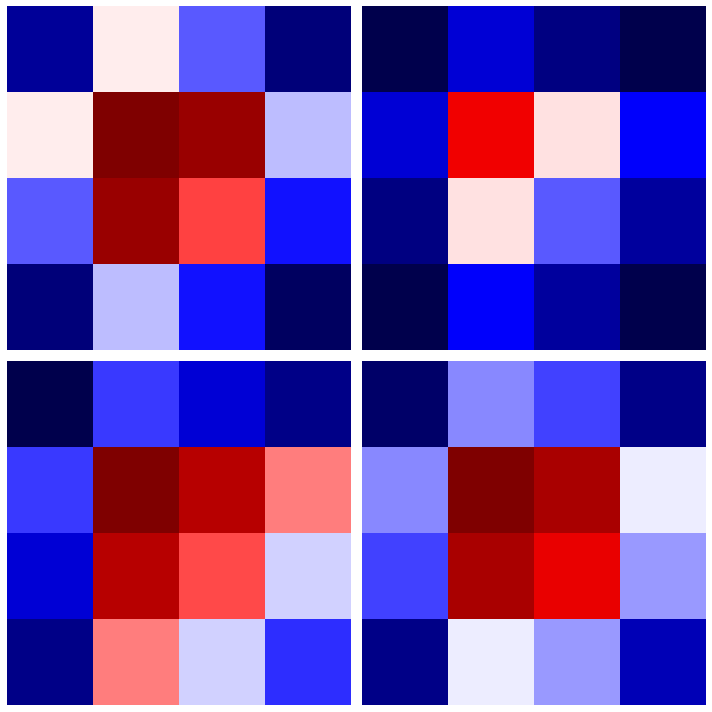

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.set_axis_off()
        
    #print(cov_samples_2001[i])
    im = ax.imshow(cov_samples_2001[i], vmin=v_min, vmax=v_max, aspect='auto', cmap='seismic')

plt.tight_layout()
plt.savefig('figures/selected_cos_samples_2001.pdf')

plt.show();

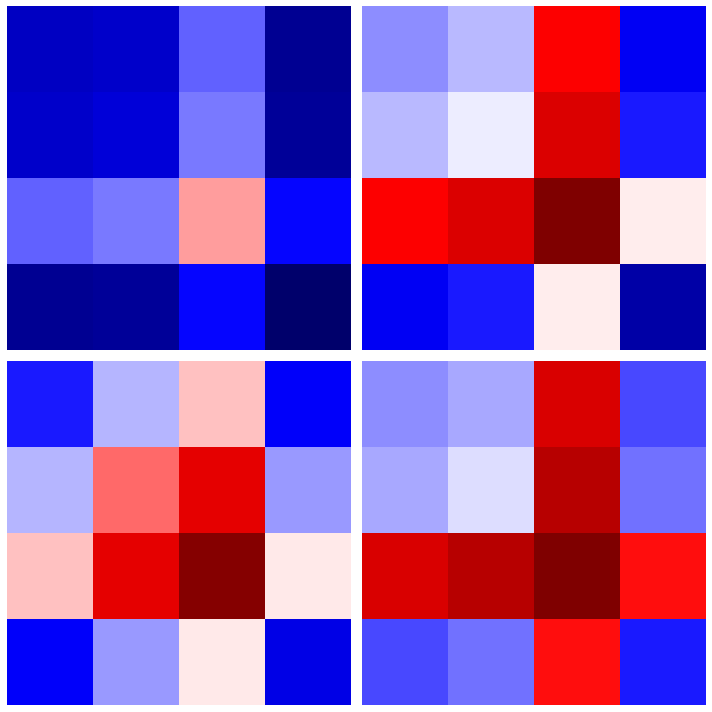

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.set_axis_off()

    im = ax.imshow(cov_samples_2006[i], vmin=v_min, vmax=v_max, aspect='auto', cmap='seismic')

plt.tight_layout()
plt.savefig('figures/selected_cos_samples_2006.pdf')

plt.show();

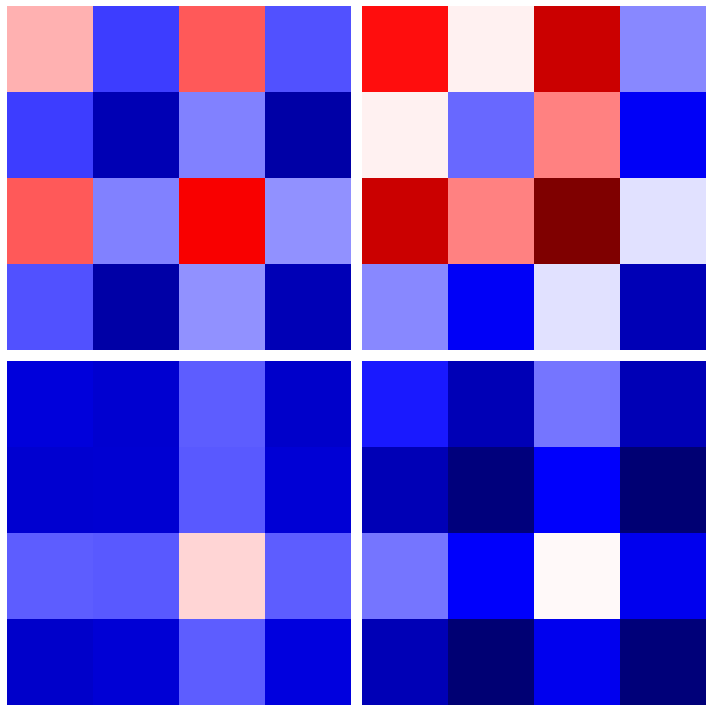

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.set_axis_off()

    im = ax.imshow(cov_samples_2009[i], vmin=v_min, vmax=v_max, aspect='auto', cmap='seismic')

plt.tight_layout()
plt.savefig('figures/selected_cos_samples_2009.pdf')

plt.show();

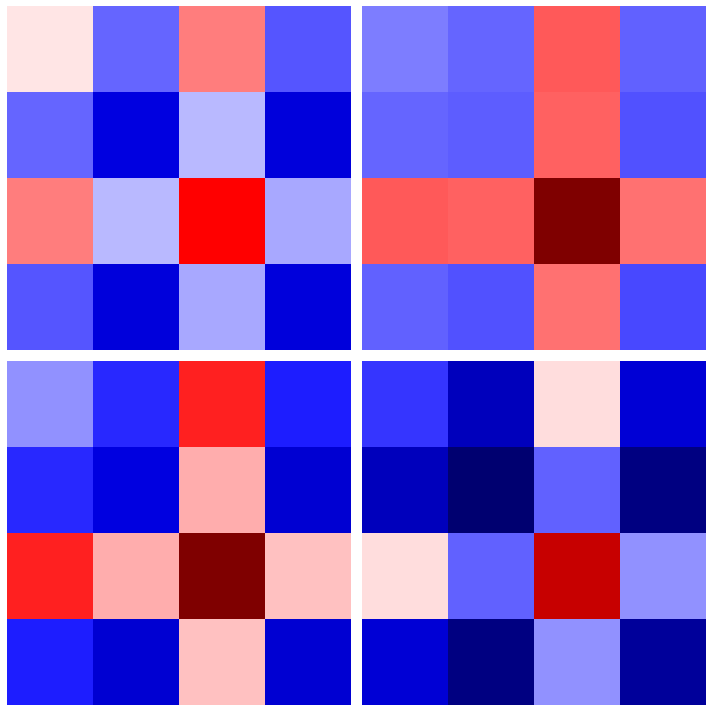

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.set_axis_off()
    
    im = ax.imshow(cov_samples_2015[i], vmin=v_min, vmax=v_max, aspect='auto', cmap='seismic')

plt.tight_layout()
plt.savefig('figures/selected_cos_samples_2015.pdf')

plt.show();

In [38]:
year_months_idxs = np.arange(0+2, 235+12+2, 12)

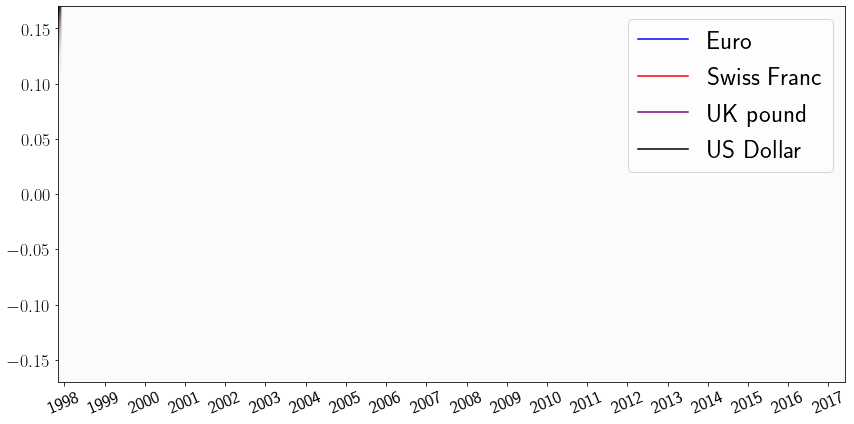

In [39]:
# plot Gaussians

plt.figure(figsize=(12,6))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=18)


plt.plot(x1, label="Euro", color='blue')
plt.plot(x2, label="Swiss Franc", color='red')
plt.plot(x3, label="UK pound", color='purple')
plt.plot(x4, label="US Dollar", color='black')

plt.xticks(year_months_idxs, year_labels, rotation = 23)

margin = 0.17

def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


yy = np.linspace(-margin, margin, 1000).reshape([1000, 1])

Ppost1 = GaussPDFscaled(
    yy, x1, v1
)  # shading by local marginal pdf

Ppost2 = GaussPDFscaled(
    yy, x2, v2
)  # shading by local marginal pdf

Ppost3 = GaussPDFscaled(
    yy, x3, v3
)  # shading by local marginal pdf

Ppost4 = GaussPDFscaled(
    yy, x4, v4
)  # shading by local marginal pdf

plt.imshow(
    Ppost1,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Blues",
    alpha=0.8,
)

plt.imshow(
    Ppost2,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Reds",
    alpha=0.5,
)


plt.imshow(
    Ppost3,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Purples",
    alpha=0.4,
)

plt.imshow(
    Ppost4,
    extent=[0, 235, -margin, margin],
    aspect="auto",
    origin="lower",
    cmap="Greys",
    alpha=0.3,
)



plt.legend(prop={'size': 25})
plt.tight_layout()
plt.savefig('figures/currency_covariances_GP.pdf')
plt.show();

## Plot the correlation coefficients for the Swiss Franc, the UK Pound and the US Dollar with the EURO for many samples

In [40]:
#choose only the first row correlations (without the correlation for the Euro itself)
cov_samples_euro = cov_samples_sqr[:, :, 0, :]
cov_samples_euro_mean = cov_samples_euro.mean(0)
cov_samples_euro_std = cov_samples_euro.std(0)

cov_samples_euro_mean_var = cov_samples_euro_mean[:,0]
cov_samples_euro_mean_sf = cov_samples_euro_mean[:,1]
cov_samples_euro_mean_bp = cov_samples_euro_mean[:,2]
cov_samples_euro_mean_usd = cov_samples_euro_mean[:,3]

cov_samples_euro_std_var = cov_samples_euro_std[:,0]
cov_samples_euro_std_sf = cov_samples_euro_std[:,1]
cov_samples_euro_std_bp = cov_samples_euro_std[:,2]
cov_samples_euro_std_usd = cov_samples_euro_std[:,3]

In [41]:
print(cov_samples_sqr[-1, -1, :, :])

#calculate the correlation coefficients for all matrices
corr_samples = np.zeros_like(cov_samples_sqr)
for i in range(n_curr):
    for j in range(n_curr):
        corr_samples[:, :, i, j] = cov_samples_sqr[:, :, i, j]/(np.sqrt(cov_samples_sqr[:, :, i, i] * cov_samples_sqr[:, :, j, j]))

print(corr_samples[-1, -1, :, :])

#choose only the first row correlations (without the correlation for the Euro itself)
corr_samples_euro = np.zeros((n_GP_samples, corr_samples.shape[1], n_curr-1))
corr_samples_euro = corr_samples[:, :, 0, 1:n_curr]
corr_samples_euro_mean = corr_samples_euro.mean(0)
corr_samples_euro_std = corr_samples_euro.std(0)

corr_samples_euro_mean_sf = corr_samples_euro_mean[:,0]
corr_samples_euro_mean_bp = corr_samples_euro_mean[:,1]
corr_samples_euro_mean_usd = corr_samples_euro_mean[:,2]

corr_samples_euro_std_sf = corr_samples_euro_std[:,0]
corr_samples_euro_std_bp = corr_samples_euro_std[:,1]
corr_samples_euro_std_usd = corr_samples_euro_std[:,2]

[[1.06268657 0.68267534 1.07240892 0.73126392]
 [0.68267534 0.45197713 0.70553188 0.46979431]
 [1.07240892 0.70553188 1.14540346 0.73447125]
 [0.73126392 0.46979431 0.73447125 0.50443521]]
[[1.         0.98503892 0.97202756 0.99877774]
 [0.98503892 1.         0.98057127 0.98389062]
 [0.97202756 0.98057127 1.         0.96625745]
 [0.99877774 0.98389062 0.96625745 1.        ]]


In [42]:
corr_samples_euro_sf = corr_samples_euro[:,:,0]
corr_samples_euro_bp = corr_samples_euro[:,:,1]
corr_samples_euro_usd = corr_samples_euro[:,:,2]

x = T_x

In [43]:
var_samples_euro = cov_samples_euro[:,:,0]
cov_samples_euro_sf = cov_samples_euro[:,:,1]
cov_samples_euro_bp = cov_samples_euro[:,:,2]
cov_samples_euro_usd = cov_samples_euro[:,:,3]

x = T_x

(50, 235)


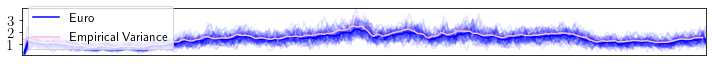

In [44]:
# plot the variances for EURO

fig = plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=13

print(var_samples_euro.shape)
for s in var_samples_euro:
    plt.plot(x, s, alpha=0.1, color='blue');

plt.plot(x, cov_samples_euro_mean_var, alpha=1, color='blue', label='Euro') 
plt.xticks([])
plt.margins(0,0)

#plot empirical correlations in blue
plt.plot(cov_emp_euro, label="Empirical Variance", color='pink')

plt.legend(prop={'size': legend_size})
plt.tight_layout()
plt.savefig('figures/currency_var_samples_euro.pdf')
plt.show();

(50, 235)


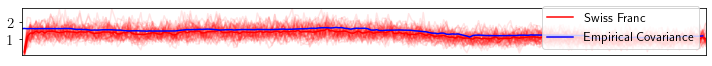

In [45]:
# plot the covariances for Swiss Franc

fig = plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=13

print(cov_samples_euro_sf.shape)
for s in cov_samples_euro_sf:
    plt.plot(x, s, alpha=0.1, color='red');

plt.plot(x, cov_samples_euro_mean_sf, alpha=1, color='red', label='Swiss Franc') 
plt.xticks([])
plt.margins(0,0)

#plot empirical correlations in blue
plt.plot(cov_emp_sf, label="Empirical Covariance", color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()

plt.savefig('figures/currency_cov_samples_SF.pdf')
plt.show();

(50, 235)


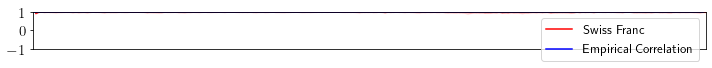

In [46]:
# plot the correlations for Swiss Franc

plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=13

print(corr_samples_euro_sf.shape)
for s in corr_samples_euro_sf:
    plt.plot(x, s, alpha=0.1, color='red');

plt.plot(x, corr_samples_euro_mean_sf, alpha=1, color='red', label='Swiss Franc') 
plt.xticks([])
plt.ylim(-1,1)
plt.margins(0,0)

#plot empirical correlations in blue
plt.plot(corr_emp_sf, label="Empirical Correlation", color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()
plt.savefig('figures/currency_corr_samples_SF.pdf')
plt.show();

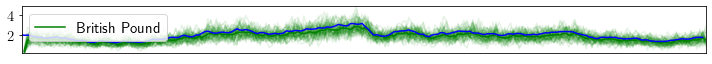

In [47]:
# plot for British Pound covs

fig = plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=15


for s in cov_samples_euro_bp:
    plt.plot(x, s, alpha=0.1, color='green');

plt.plot(x, cov_samples_euro_mean_bp, alpha=1, color='green', label='British Pound') 
plt.xticks([])
#plt.ylim(-1,1)
plt.margins(0,0)

# compare to empirical correlation in blue
plt.plot(cov_emp_bp, color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()

plt.savefig('figures/currency_cov_samples_BP.pdf')
plt.show();

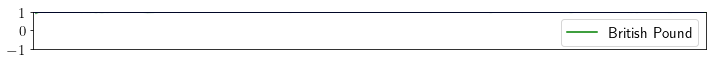

In [48]:
# plot for British Pound

plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=15


for s in corr_samples_euro_bp:
    plt.plot(x, s, alpha=0.1, color='green');

plt.plot(x, corr_samples_euro_mean_bp, alpha=1, color='green', label='British Pound') 
plt.xticks([])
plt.ylim(-1,1)
plt.margins(0,0)

# compare to empirical correlation in blue
plt.plot(corr_emp_bp, color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()
plt.savefig('figures/currency_corr_samples_BP.pdf')
plt.show();

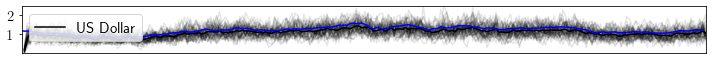

In [49]:
# plot for US Dollar

fig = plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=15

for s in cov_samples_euro_usd:
    plt.plot(x, s, alpha=0.1, color='black');

plt.plot(x, cov_samples_euro_mean_usd, alpha=1, color='black', label='US Dollar') 
plt.xticks([])
plt.margins(0,0)

#compare to empirical correlation in blue
plt.plot(cov_emp_usd, color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()

plt.savefig('figures/currency_cov_samples_USD.pdf')
plt.show();

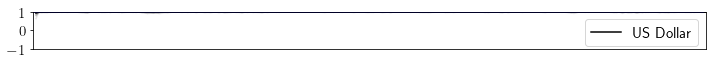

In [50]:
# plot for US Dollar

plt.figure(figsize=(10, 1))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)

legend_size=15

for s in corr_samples_euro_usd:
    plt.plot(x, s, alpha=0.1, color='black');

plt.plot(x, corr_samples_euro_mean_usd, alpha=1, color='black', label='US Dollar') 
plt.xticks([])
plt.ylim(-1,1)
plt.margins(0,0)

#compare to empirical correlation in blue
plt.plot(corr_emp_usd, color='blue')

plt.legend(prop={'size': legend_size})
plt.tight_layout()
plt.savefig('figures/currency_corr_samples_USD.pdf')
plt.show();